## Main notebook script for PV shadow analysis.

Uses the refactored pv_analysis module with:
  - SiteConfig with inverter_utc_offset_hours=3 (confirmed fixed UTC+3)
  - Pre-smoothed shadow matrix (done once)
  - Beam/diffuse separated shadow attenuation
  - Robust timezone handling (no magic-number offsets)
  - No duplicate evaluation loops
  - Validated inverter data loading with gap reporting

In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pv_analysis_re import (
    SiteConfig,
    find_clear_days,
    load_and_smooth_shadow_matrix,
    load_extra_data_csv,
    load_inverter_data,
    pv_analysis,
    compute_metrics,
    evaluate_performance,
    print_performance_summary,
    plot_real_vs_predicted_scatter,
    save_all_day_plots,
    calculate_api_grid,
    plot_api_map,
)

# Project modules (unchanged)
from shadow_matrix_simulation_re import create_shadow_matrix

try:
    from visual_utils import plot_shadow_matrix_with_sunpaths
except ImportError:
    plot_shadow_matrix_with_sunpaths = None

In [10]:
cfg = SiteConfig(
    latitude=62.979849,
    longitude=27.648656,
    tilt_deg=12.0,
    azimuth_deg=170.0,
    nominal_power_kw=3.96,  # 15% derating for system losses (cabling, inverter inefficiency, etc.)
    system_efficiency=0.8,
    local_tz="Europe/Helsinki",
    inverter_utc_offset_hours=3,  # Fronius Symo logs in fixed UTC+3
    forecast_shift_minutes=-30, # Shift forecasts 30 minutes earlier to better align with measured data
    window_size=(3, 3),
    interval="5min",
    interval_minutes=5.0,
)

# --- File Paths ---
RAD_FILE       = "data/pvdata/Kuopio Savilahti 1.4.2021 - 1.10.2021_rad.csv"
TEMP_WIND_FILE = "data/pvdata/Kuopio Savilahti 1.4.2021 - 1.10.2021_temp_wind.csv"
CLEAR_MINUTES  = "data/Clear_sky_minutes_kuopio_RH16.txt"
PV_EXCEL       = "data/pvdata/pv_21.xlsx"

LIDAR_FILE     = "output/reclassified_final_v5.laz"
SHADOW_DIR     = "results/shadow_matrix_results_SE_pro"
SHADOW_FN      = "shadow_attenuation_matrix_conecasting_SE_v10.csv"
SHADOW_CSV     = f"{SHADOW_DIR}/{SHADOW_FN}"
EXTRA_DATA_DIR = "output"

In [3]:
# %% --- 1. Find Clear Days ---
clear_days = find_clear_days(CLEAR_MINUTES, threshold=0.8)
print(clear_days.head(10))

Found 20 clear days (threshold: Q3 + 0.8 * IQR = 650 minutes)
          Date  LineCount
72  2021-07-03        914
73  2021-07-04        872
50  2021-06-09        821
52  2021-06-11        801
51  2021-06-10        796
30  2021-05-13        796
29  2021-05-12        791
45  2021-06-04        781
83  2021-07-14        759
94  2021-07-26        747


In [4]:
# %% --- 2. Load & Inspect Extra Data for First Clear Day ---
second_day = clear_days["Date"].iloc[1]
extra_data_df = load_extra_data_csv(f"{EXTRA_DATA_DIR}/extra_data_{second_day}.csv", cfg=cfg, recompute_albedo=True)
print(extra_data_df.head())

                           dni   dhi   ghi      T  wind  albedo
time                                                           
2021-07-04 00:00:00+00:00  0.0  0.00 -0.36  18.10  0.72     0.2
2021-07-04 00:05:00+00:00  0.0  0.02  0.02  18.08  0.96     0.2
2021-07-04 00:10:00+00:00  0.0  0.60  0.30  18.36  1.48     0.2
2021-07-04 00:15:00+00:00  0.0  1.68  0.48  19.12  1.82     0.2
2021-07-04 00:20:00+00:00  0.0  2.14  1.22  19.20  1.16     0.2


In [11]:
# %% --- 3. Create Shadow Matrix (ray-tracing — slow, run once) ---
# Uncomment to regenerate:
# shadow_matrix_raw = create_shadow_matrix(
#     lidar_file_path=LIDAR_FILE, voxel_size=2.0,
#     output_dir=SHADOW_DIR, output_fn=SHADOW_FN,
#     offset_from_roof=-0.5, skip_dist=3.0,
# )


# %% --- 4. Load & Pre-smooth Shadow Matrix (done ONCE) ---
shadow_matrix = load_and_smooth_shadow_matrix(SHADOW_CSV, window_size=cfg.window_size)
print(f"Shadow matrix shape: {shadow_matrix.shape}  (altitude x azimuth)")

Shadow matrix shape: (91, 361)  (altitude x azimuth)


Loading shadow matrix...
Calculating seasonal sun paths...


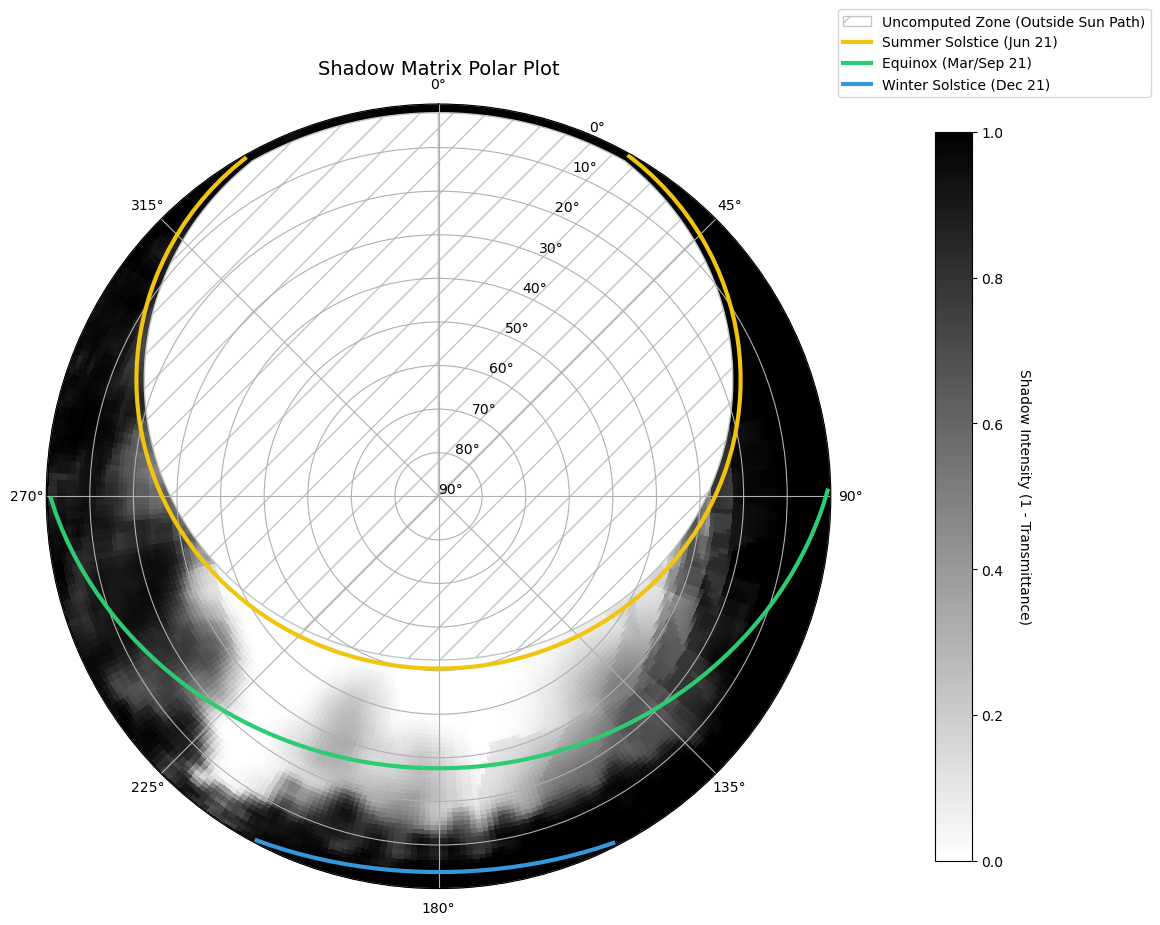

In [12]:
# %% --- 5. Visualise Shadow Matrix ---
if plot_shadow_matrix_with_sunpaths is not None:
    plot_shadow_matrix_with_sunpaths(SHADOW_CSV, fill_missing=True)

In [7]:
# %% --- 6. Load Inverter Data ---
pv_df = load_inverter_data(PV_EXCEL, expected_interval_min=cfg.interval_minutes)
print(f"Range: {pv_df['Timestamp'].min()} -> {pv_df['Timestamp'].max()}")
print(pv_df.head())

Inverter data: 102,263 records, 102235/102262 normal intervals, 27 gaps
  Largest gaps: [965. 925. 905. 875. 825.] min
Range: 2021-01-01 00:00:00 -> 2021-12-31 23:55:00
            Timestamp  Energy_Wh  Power_W
0 2021-01-01 00:00:00        0.0      0.0
1 2021-01-01 00:05:00        0.0      0.0
2 2021-01-01 00:10:00        0.0      0.0
3 2021-01-01 00:15:00        0.0      0.0
4 2021-01-01 00:20:00        0.0      0.0


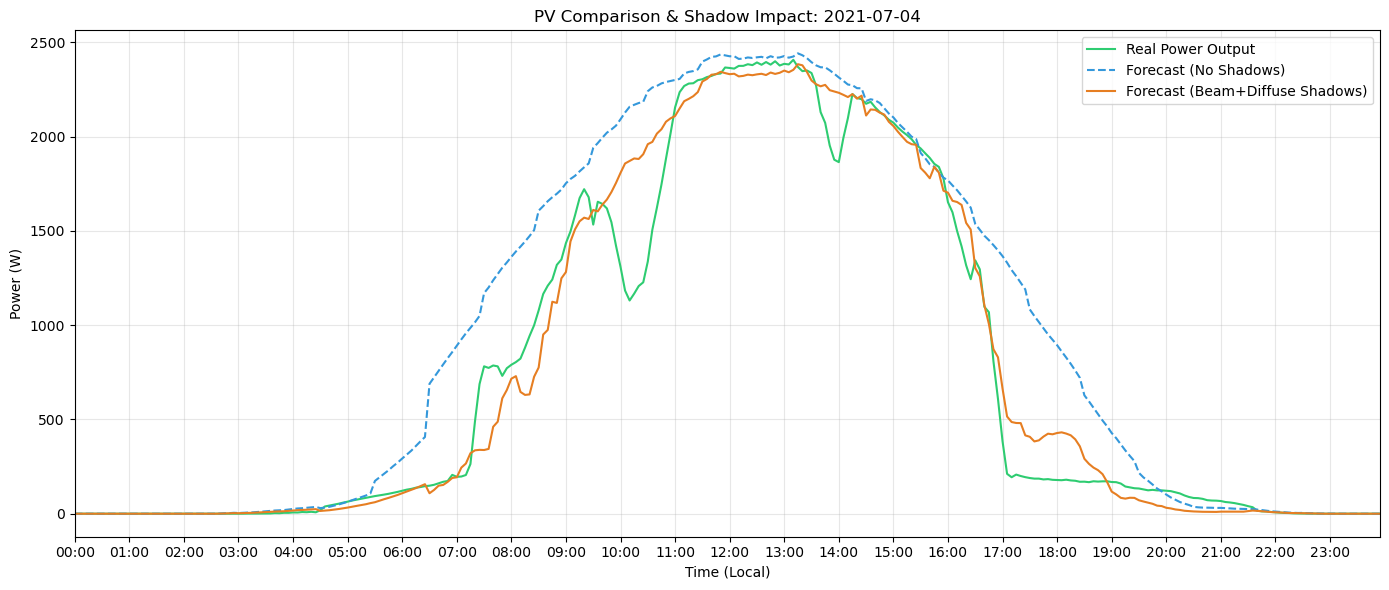

In [13]:
# %% --- 7. Single-Day Analysis (with plot) ---
day_data, forecast_base, forecast_windowed = pv_analysis(
    target_date=second_day,
    shadow_matrix=shadow_matrix,
    excel_df=pv_df,
    df_extra=extra_data_df,
    cfg=cfg,
    plot=True,
)

In [14]:
# %% --- 8. Single-Day Metrics ---
metrics_single = compute_metrics(day_data, forecast_base, forecast_windowed, cfg.interval_minutes)
print(f"\nMetrics for {second_day}:")
for k, v in metrics_single.items():
    if isinstance(v, float):
        print(f"  {k:15s}: {v:10.2f}")


Metrics for 2021-07-04:
  RMSE_Base      :     352.38
  RMSE_Shaded    :     158.36
  MAE_Base       :     208.37
  MAE_Shaded     :      86.34
  MBE_Base       :     202.49
  MBE_Shaded     :      16.62
  R2_Base        :       0.81
  R2_Shaded      :       0.96
  Real_Wh        :   17782.48
  Base_Wh        :   22642.30
  Shaded_Wh      :   18181.43


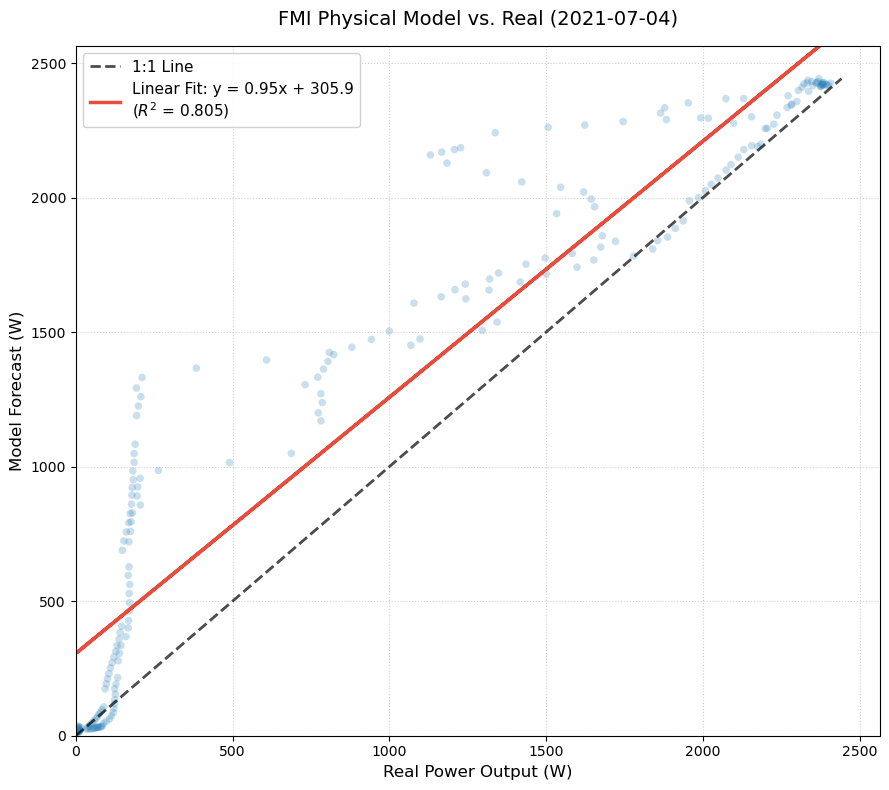

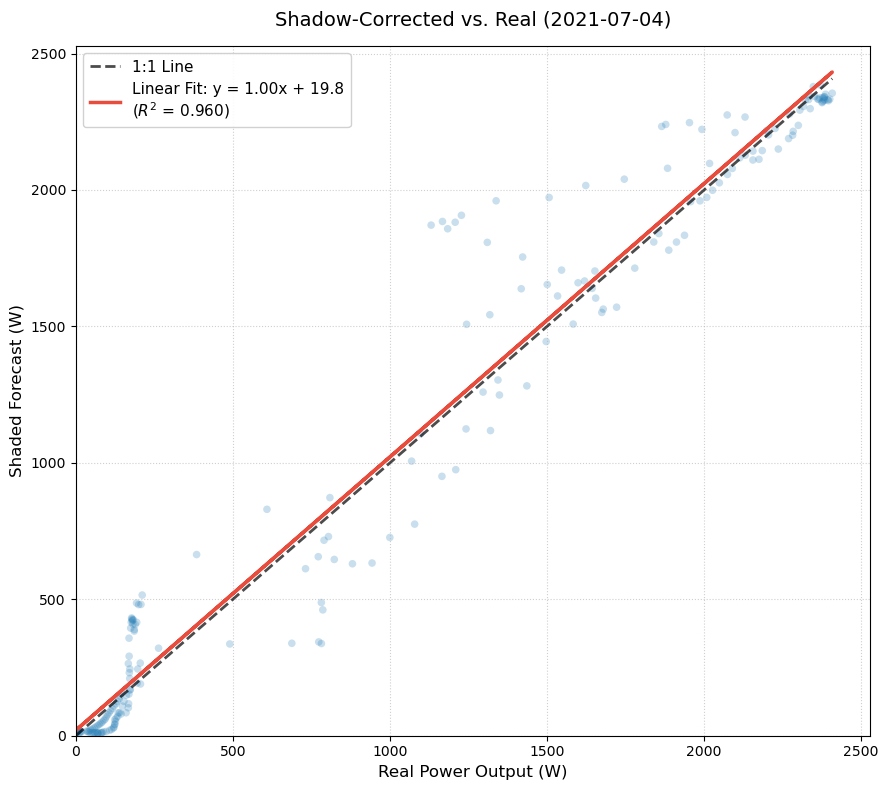

In [20]:
# %% --- 9. Scatter Plots for Single Day ---
plot_real_vs_predicted_scatter(
    day_data["Power_W"].values,
    forecast_base["output"].values,
    title=f"FMI Physical Model vs. Real ({second_day})",
    ylabel="Model Forecast (W)",
    power_threshold=10.0,
)

plot_real_vs_predicted_scatter(
    day_data["Power_W"].values,
    forecast_windowed["output_shaded"].values,
    title=f"Shadow-Corrected vs. Real ({second_day})",
    ylabel="Shaded Forecast (W)",
    power_threshold=10.0,
)

Evaluating: 100%|██████████| 20/20 [00:00<00:00, 33.21it/s]



Generating scatter plots...


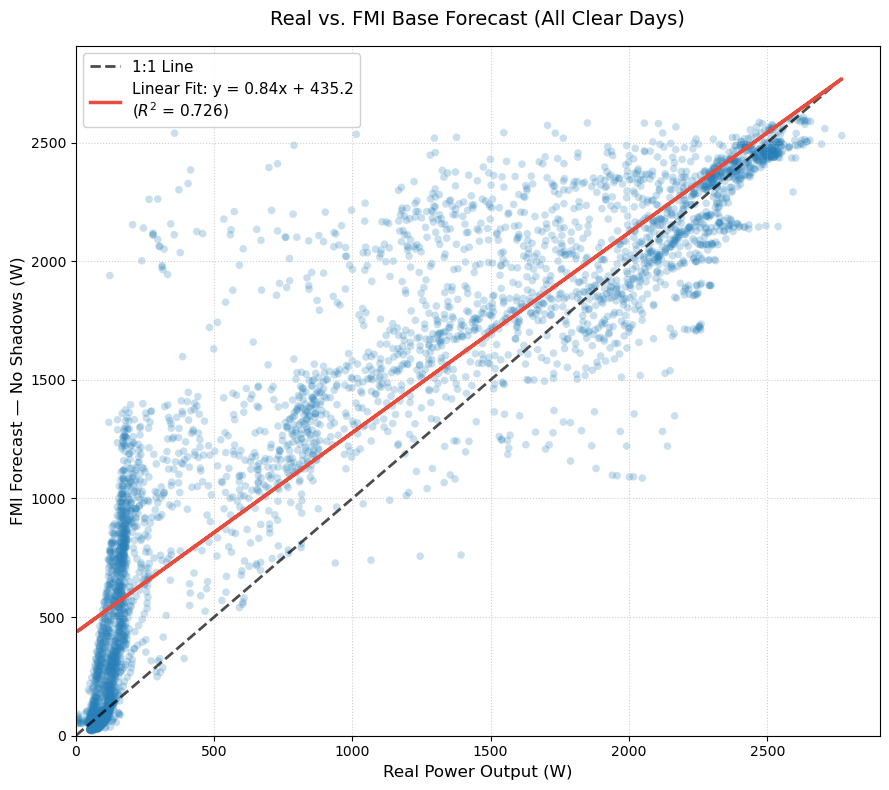

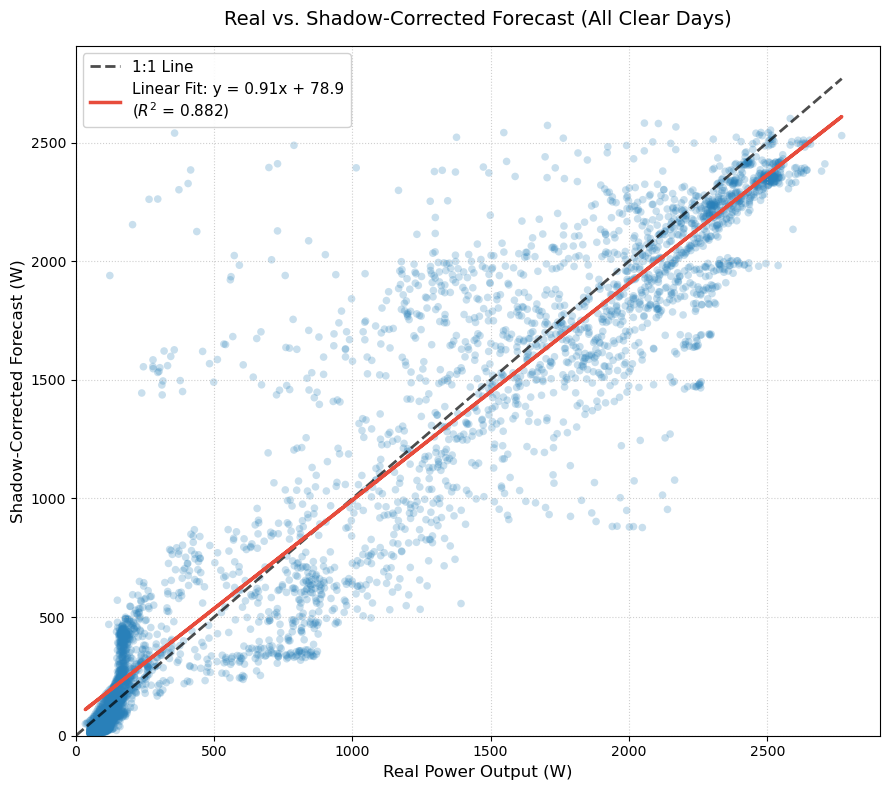


  PV FORECAST PERFORMANCE METRICS (CLEAR DAYS)

  RMSE  Base:     373.23 W
  RMSE  Shaded:   234.65 W  (+37.1%)

  MAE   Base:     218.95 W
  MAE   Shaded:   129.75 W  (+40.7%)

  MBE   Base:    +178.64 W
  MBE   Shaded:    -7.07 W

  R2    Base:      0.738
  R2    Shaded:    0.885

  --- Energy Yield ---
  Real:      324.76 kWh
  Base:      410.51 kWh  (+26.4%)
  Shaded:    321.37 kWh  (-1.0%)


In [22]:
# %% --- 10. Multi-Day Batch Evaluation ---
def _load_cached_extra(date_obj):
    """Load pre-cached extra_data CSV for a date, recomputing albedo."""
    try:
        return load_extra_data_csv(
            f"{EXTRA_DATA_DIR}/extra_data_{date_obj}.csv", cfg=cfg
        )
    except FileNotFoundError:
        print(f"  Warning: No extra data for {date_obj}, skipping.")
        return None


results_df, all_real, all_pred_shaded, all_pred_base = evaluate_performance(
    significant_days_df=clear_days,
    shadow_matrix=shadow_matrix,
    excel_df=pv_df,
    extra_data_loader=_load_cached_extra,
    cfg=cfg,
)

print_performance_summary(results_df)

In [17]:
# %% --- 10b. Save All Daily Comparison Plots ---
save_all_day_plots(
    significant_days_df=clear_days,
    shadow_matrix=shadow_matrix,
    excel_df=pv_df,
    extra_data_loader=_load_cached_extra,
    output_dir="results/daily_plots",
    cfg=cfg,
)


Saving daily plots: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]


Saved 20 daily plots to results/daily_plots/


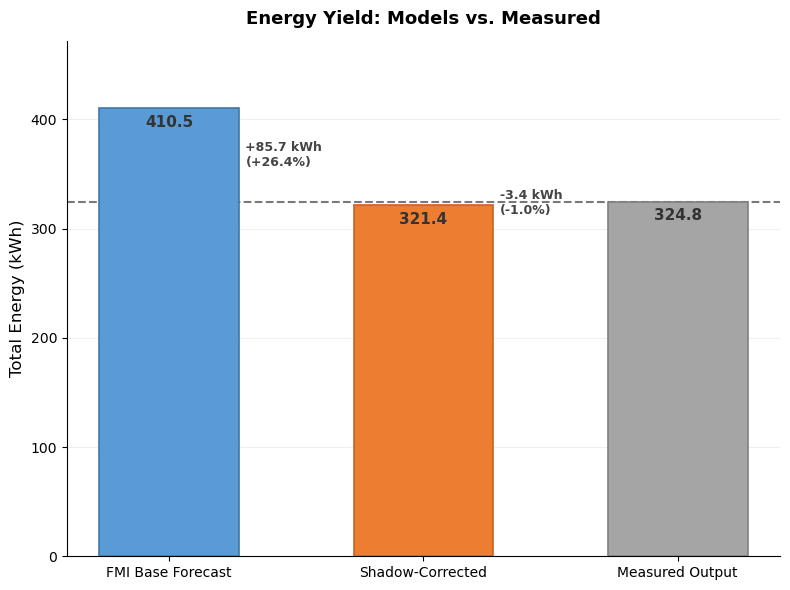

In [18]:
# %% --- 11. Energy Yield Bar Chart ---
def plot_energy_bar_chart(results_df: pd.DataFrame):
    """Comparative bar chart: clearsky vs corrected vs real energy yield."""
    totals = results_df[["Real_Wh", "Base_Wh", "Shaded_Wh"]].sum() / 1000

    labels = ["FMI Base Forecast", "Shadow-Corrected", "Measured Output"]
    values = [totals["Base_Wh"], totals["Shaded_Wh"], totals["Real_Wh"]]
    target = values[2]

    fig, ax = plt.subplots(figsize=(8, 6))

    # Muted, professional palette
    colors = ["#5B9BD5", "#ED7D31", "#A5A5A5"]
    edge_colors = ["#4178A4", "#C46420", "#808080"]
    bars = ax.bar(labels, values, color=colors, edgecolor=edge_colors,
                  width=0.55, linewidth=1.2, zorder=3)

    # Reference line
    ax.axhline(y=target, color="#404040", ls="--", lw=1.5, alpha=0.7, zorder=2)
    # ax.text(2.35, target, f"{target:,.1f} kWh", va="center", fontsize=9,
    #         color="#404040", fontstyle="italic")

    # Value labels on bars
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, h - max(values) * 0.015,
                f"{h:,.1f}", ha="center", va="top", fontsize=11, fontweight="bold",
                color="#333333")

    # Error annotations for first two bars
    for i in range(2):
        err = values[i] - target
        cx = bars[i].get_x() + bars[i].get_width() / 2
        h = bars[i].get_height()
        sign = "+" if err >= 0 else ""
        err_pct = err / target * 100

        # Small annotation to the right of each bar
        ax.annotate(
            f"{sign}{err:.1f} kWh\n({sign}{err_pct:.1f}%)",
            xy=(cx + 0.3, (h + target) / 2),
            fontsize=9, color="#444444", ha="left", va="center",
            fontweight="bold",
        )
        # Thin bracket line
        # ax.plot([cx + 0.25, cx + 0.25], [min(h, target), max(h, target)],
        #         color="#999999", lw=1, zorder=4)

    ax.set_ylabel("Total Energy (kWh)", fontsize=12)
    ax.set_title("Energy Yield: Models vs. Measured", fontsize=13, pad=12, fontweight="bold")
    ax.set_ylim(0, max(values) * 1.15)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="y", alpha=0.2, zorder=0)
    ax.tick_params(axis="x", labelsize=10)

    # n_days = len(results_df)
    # ax.text(0.02, 0.97, f"{n_days} clear days", transform=ax.transAxes,
    #         fontsize=9, va="top", color="#888888")

    plt.tight_layout()
    plt.show()



if not results_df.empty:
    plot_energy_bar_chart(results_df)

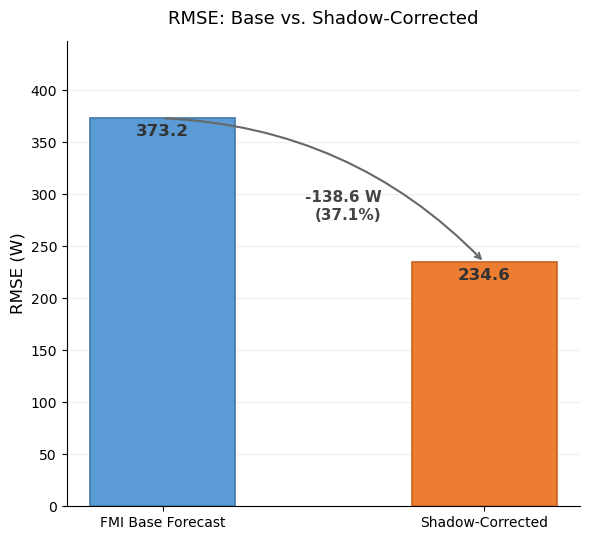

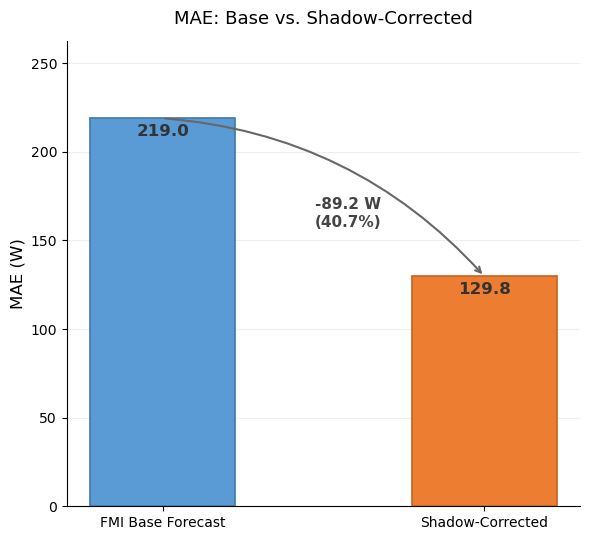

In [19]:
# %% --- 12. RMSE & MAE Bar Charts ---
def _plot_metric_comparison(base_val, shaded_val, metric_name, unit="W",
                            results_df=None):
    """Generic paired bar chart for a single metric, matching energy chart style."""
    imp = base_val - shaded_val
    imp_pct = (imp / base_val) * 100 if base_val != 0 else 0

    labels = ["FMI Base Forecast", "Shadow-Corrected"]
    values = [base_val, shaded_val]

    fig, ax = plt.subplots(figsize=(6, 5.5))

    colors = ["#5B9BD5", "#ED7D31"]
    edge_colors = ["#4178A4", "#C46420"]
    bars = ax.bar(labels, values, color=colors, edgecolor=edge_colors,
                  width=0.45, linewidth=1.2, zorder=3)

    # Value labels on bars
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, h - max(values) * 0.015,
                f"{h:,.1f}", ha="center", va="top", fontsize=12,
                fontweight="bold", color="#333333")

    # Improvement annotation with arrow between bar tops
    cx0 = bars[0].get_x() + bars[0].get_width() / 2
    cx1 = bars[1].get_x() + bars[1].get_width() / 2
    mid_x = (cx0 + cx1) / 2
    mid_y = (values[0] + values[1]) / 2

    ax.annotate(
        "", xy=(cx1, values[1]), xytext=(cx0, values[0]),
        arrowprops=dict(arrowstyle="->", color="#676767", lw=1.5,
                        connectionstyle="arc3,rad=-0.2"),
        zorder=4,
    )
    ax.text(mid_x + 0.18, mid_y,
            f"-{imp:.1f} {unit}\n({imp_pct:.1f}%)",
            fontsize=11, color="#444444", ha="right", va="top",
            fontweight="bold")

    ax.set_ylabel(f"{metric_name} ({unit})", fontsize=12)
    ax.set_title(f"{metric_name}: Base vs. Shadow-Corrected", fontsize=13, pad=12)
    ax.set_ylim(0, max(values) * 1.2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="y", alpha=0.2, zorder=0)
    ax.tick_params(axis="x", labelsize=10)

    plt.tight_layout()
    plt.show()


if not results_df.empty:
    _plot_metric_comparison(
        results_df["RMSE_Base"].mean(),
        results_df["RMSE_Shaded"].mean(),
        "RMSE", "W", results_df,
    )
    _plot_metric_comparison(
        results_df["MAE_Base"].mean(),
        results_df["MAE_Shaded"].mean(),
        "MAE", "W", results_df,
    )

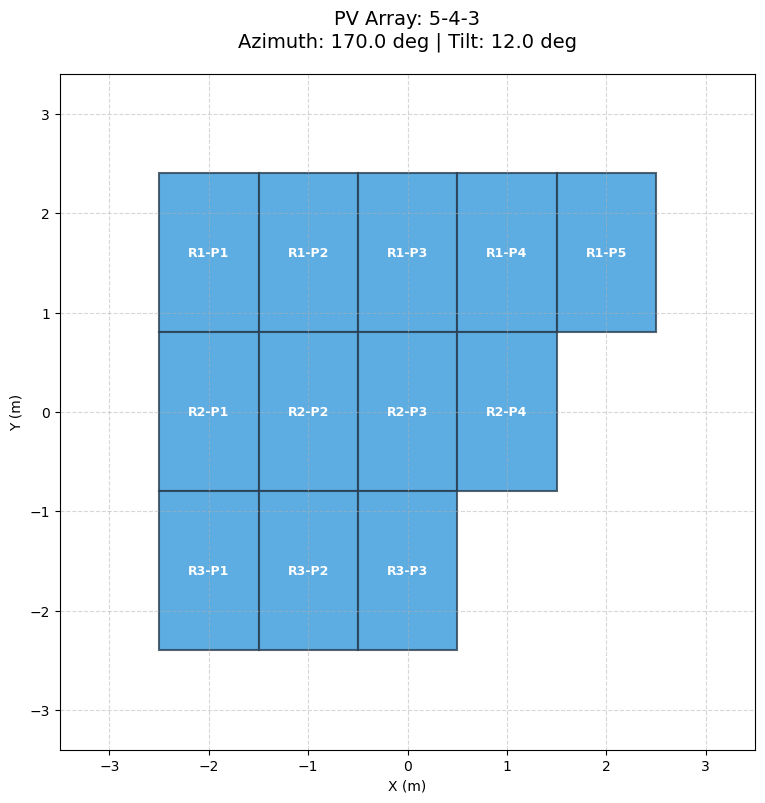

In [15]:
# %% --- 13. PV Array Diagram ---
def generate_array_diagram(row_config=(5, 4, 3), pw=1.0, ph=1.6):
    """Top-down footprint of the PV array."""
    import matplotlib.patches as patches

    total_h = len(row_config) * ph
    max_w = max(row_config) * pw

    fig, ax = plt.subplots(figsize=(8, 8))
    y = total_h / 2
    for r_idx, n in enumerate(row_config):
        y -= ph
        for p_idx in range(n):
            x = -max_w / 2 + p_idx * pw
            rect = patches.Rectangle(
                (x, y), pw, ph, lw=1.5,
                edgecolor="#2c3e50", facecolor="#3498db", alpha=0.8)
            ax.add_patch(rect)
            ax.text(x + pw / 2, y + ph / 2, f"R{r_idx+1}-P{p_idx+1}",
                    color="white", weight="bold", fontsize=9, ha="center", va="center")

    ax.set_xlim(-max_w / 2 - 1, max_w / 2 + 1)
    ax.set_ylim(-total_h / 2 - 1, total_h / 2 + 1)
    ax.set_aspect("equal")
    ax.set_title(
        f"PV Array: {'-'.join(map(str, row_config))}\n"
        f"Azimuth: {cfg.azimuth_deg} deg | Tilt: {cfg.tilt_deg} deg",
        fontsize=14, pad=20)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.grid(True, ls="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig("pv_array_layout.pdf", format="pdf", bbox_inches="tight", dpi=300)
    plt.show()


generate_array_diagram()

Loading LiDAR data from output/reclassified_final_v5.laz...
API grid: 250 x 250 at 2.0 m


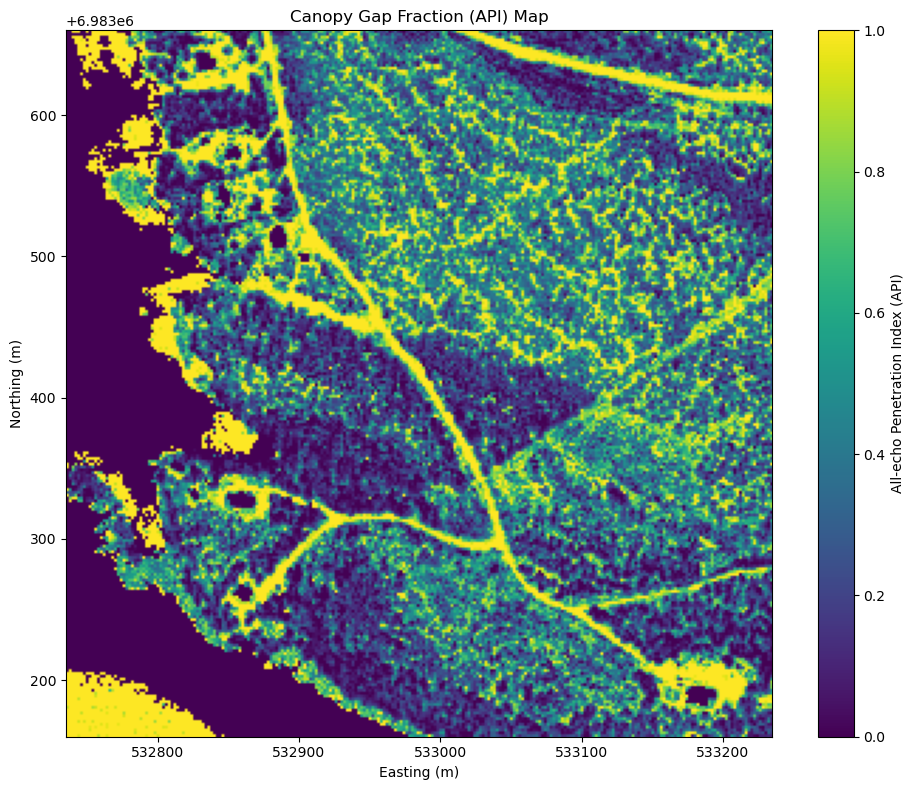

In [16]:
# %% --- 14. API Map ---
api_grid, extent = calculate_api_grid(LIDAR_FILE, grid_size=2.0)
plot_api_map(api_grid, extent)